In [1]:
%pylab inline
import glob
import os
import re
import seaborn as sns
import sys
from ecdfplotting import *
from tqdm import tqdm_notebook as tqdm
idx = pd.IndexSlice

Populating the interactive namespace from numpy and matplotlib


In [26]:
CUTOFF = 3600
TIMEOUT_TIME = CUTOFF * 10

In [50]:
numeric_const_pattern = '[+-]?\d+(?:\.\d+)?(?:[eE][+-]\d+)?'#r"[+\-]?(?:0|[1-9]\d*)(?:\.\d*)?(?:[eE][+\-]?\d+)?"
REGEX = re.compile(r"(%s)m(%s)s" % (numeric_const_pattern, numeric_const_pattern))

def parse_time(line):
    """You are dumb and forgot to tell time to make things easy to parse, so..."""
    user = re.match(REGEX, line.split('\t')[1])
    minutes = float(user.group(1))
    seconds = float(user.group(2))
    time = minutes * 60 + seconds
    return time

def check_eq(lines):
    foundEq = False
    for line in lines:
        if line.startswith('Expected utility for each player under a sample eqlm'):
            foundEq = True
            break
    return foundEq

def parse_runsolver_time(lines):
    def float_regex():
        return '[+-]?\d+(?:\.\d+)?(?:[eE][+-]\d+)?'
    
    cpu_pattern1 = re.compile('runsolver_cputime: (%s)' % (float_regex()))
    cpu_match1 = re.search(cpu_pattern1, lines)

    cpu_pattern2 = re.compile('CPU time \\(s\\): (%s)' % (float_regex()))
    cpu_match2 = re.search(cpu_pattern2, lines)

    if (cpu_match1):
        time = float(cpu_match1.group(1))
    if (cpu_match2):
        time = float(cpu_match2.group(1))

#     if (cpu_match1 or cpu_match2):
#         print "CPUTime is %f" % time
    return time

records = []

not_finished = []
for output in tqdm(glob.glob('/ubc/cs/research/arrow/newmanne/positronic-economist/output/*.output')):
    parts = os.path.basename(output).split('.')[0].split('_')
    gnm_seed = parts[-1]
    bagg_type = parts[-2]
    posec_seed = parts[-4]
    n = parts[-5]
    name = '_'.join(reversed(parts[-6::-1]))
    
    lines = read_lines(output)
    solved = check_eq(lines)
    if solved:
        if lines[-2].startswith('user') and lines[-1].startswith('sys'):
            time = parse_time(lines[-2]) + parse_time(lines[-1])
        else:
            time = parse_runsolver_time('\n'.join(lines))
        solved = "SAT"
    else:
        time = TIMEOUT_TIME
        solved = "TIMEOUT"
        not_finished.append(output)
    record = {'gnm_seed': int(gnm_seed),
      'bagg_type': bagg_type,
     'posec_seed': int(posec_seed),
     'n_players': int(n),
      'game': name,
       'runtime': time,
        'result': solved}
    records.append(record)

df = pd.DataFrame.from_records(records)
print len(df), len(not_finished)
df['bad'] = df['game'].apply(lambda game: 'bad' in game)
df['game'] = df['game'].apply(lambda game: game.replace('bad_',''))
def labeler(bagg, bad):
    if bad:
        if bagg == 'WBSI':
            return 'NFG'
        else:
            return 'BBSI'
    else:
        if bagg == 'WBSI':
            return 'WBSI'
        else:
            return 'WBSI + BBSI'
    return ':'.join([bagg,str(bad)])
df['config'] = np.vectorize(labeler)(df['bagg_type'], df['bad'])



7743 1359


In [51]:
df.to_csv('gnm.csv', index=False)

In [ ]:
# for n in [4, 10]:
#     df2 = df[df['n_players'] == n]
#     df2.set_index(['config', 'gnm_seed', 'posec_seed'], inplace=True)
#     for game in ['gsp', 'gfp', 'two_approval']:
#         plt.figure()
#         plotECDFsFromDF(df2[df2['game'] == game])
#         title = game + '_' + str(n) + '_players'
#         plt.title(title)
#         plt.savefig('figures/' + title + '.png', dpi=300)
# g = sns.FacetGrid(df, col='game').map(plot_ecdf_from_df, 'n', 'runtime')
# plt.yscale('log')
# for name, group in df.groupby(['game', 'bagg_type', 'n']):
#     print name
#     display(group['runtime'].describe())

In [2]:
frames = []

SUBSAMPLE_EVERY = 1000
SUBSAMPLE_AFTER = 10000
MAX_ITER = 701772

# TODO: mess with granulatiry for GSP

for output in tqdm(glob.glob('/ubc/cs/research/arrow/newmanne/positronic-economist/IBR/*')):
    name = os.path.basename(output).replace('.txt','')
    matches = re.match("(.+)_n=(\d+)_seed=(\d+)_algseed=(\d+)", name).groups()
    rt_orig = pd.read_csv(output)
    if len(rt_orig) < SUBSAMPLE_AFTER:
        rt = rt_orig
        rt['iteration'] = pd.Series(range(len(rt)))
    else:
        rt = pd.concat((rt_orig.ix[:SUBSAMPLE_AFTER], rt_orig.ix[SUBSAMPLE_AFTER+1:MAX_ITER:SUBSAMPLE_EVERY]))
        rt['iteration'] = rt_orig.ix[:SUBSAMPLE_AFTER].index.values.tolist() + rt_orig.ix[SUBSAMPLE_AFTER+1:MAX_ITER:SUBSAMPLE_EVERY].index.values.tolist()
    rt['game'] = matches[0]
    rt['n'] = matches[1]
    rt['seed'] = matches[2]
    rt['ibrseed'] = matches[3]
    frames.append(rt)
ibr = pd.concat(frames)

/ubc/cs/research/arrow/newmanne/positronic-economist/IBR/GSP_n=10_seed=2_algseed=10.txt
/ubc/cs/research/arrow/newmanne/positronic-economist/IBR/GSP_n=10_seed=2_algseed=7.txt
/ubc/cs/research/arrow/newmanne/positronic-economist/IBR/GSP_n=10_seed=1_algseed=4.txt
/ubc/cs/research/arrow/newmanne/positronic-economist/IBR/GSP_n=10_seed=2_algseed=5.txt
/ubc/cs/research/arrow/newmanne/positronic-economist/IBR/GSP_n=10_seed=1_algseed=1.txt
/ubc/cs/research/arrow/newmanne/positronic-economist/IBR/GSP_n=10_seed=2_algseed=1.txt
/ubc/cs/research/arrow/newmanne/positronic-economist/IBR/GSP_n=10_seed=1_algseed=2.txt
/ubc/cs/research/arrow/newmanne/positronic-economist/IBR/GSP_n=10_seed=2_algseed=8.txt
/ubc/cs/research/arrow/newmanne/positronic-economist/IBR/GSP_n=10_seed=1_algseed=3.txt
/ubc/cs/research/arrow/newmanne/positronic-economist/IBR/GSP_n=10_seed=2_algseed=2.txt
/ubc/cs/research/arrow/newmanne/positronic-economist/IBR/GSP_n=10_seed=2_algseed=9.txt
/ubc/cs/research/arrow/newmanne/positronic

KeyboardInterrupt: 

In [ ]:
sns.set(font_scale=2)  


for game, group in ibr.groupby('game'):
    plt.figure(figsize=(15,6))
    # TODO: obviously a problem
    TIME_PER_ITER = (3600/float(group['iteration'].max()))
    group['tt'] = group['iteration'] * TIME_PER_ITER
    sns.tsplot(group, time='tt', value='max_regret', unit='ibrseed', condition='seed',color="husl", legend=False)
    plt.ylabel('Max Regret')
    plt.xlabel('Time (s)')
    plt.savefig('figures/%s_ibr.png' % (game), dpi=300)
    plt.title(game)
# plt.xscale('log')

In [ ]:
# for output in glob.glob('/ubc/cs/research/arrow/newmanne/positronic-economist/ibr/*'):
#     name = os.path.basename(output).replace('.txt','')
#     matches = re.match("(.+)_n=(\d+)_seed=(\d+)_ibrseed=(\d+)", name).groups()
#     if matches[0] == 'GFP':
#         CC = 882000
#     elif matches[0] == 'GSP':
#         CC = 25000
#     elif matches[0] == 'vote':
#         CC = 28
#     print "starting"
#     lines = read_lines(output)
#     delta = CC - len(lines)
#     if delta > 0:
#         lines += [lines[-1]] * delta
#         write_lines(lines, output)

In [ ]:
ibr.groupby('game')['iteration'].max()

In [16]:
frames = []

for output in tqdm(glob.glob('/ubc/cs/research/arrow/newmanne/positronic-economist/FP/*')):
    name = os.path.basename(output).replace('.txt','')
    matches = re.match("(.+)_n=(\d+)_seed=(\d+)_algseed=(\d+)", name).groups()
    rt_orig = pd.read_csv(output, usecols=['cputime', 'weighted_max_regret'])
    rt_orig['cputime'] -= rt_orig['cputime'][0]
    rt_orig['cputime'] = pd.to_timedelta(rt_orig['cputime'], unit='s')
    
    # 2 approval doens't have enoguh samples ot average every second without looking choppy
    if matches[0].lower() == 'two_approval':
        freq = '60s'
    else:
        freq = '1s'
    rt_orig = rt_orig.set_index('cputime').resample(freq).pad()
    rt_orig = rt_orig.reset_index()
    
    rt_orig['game'] = matches[0]
    rt_orig['n'] = int(matches[1])
    rt_orig['seed'] = int(matches[2])
    rt_orig['algseed'] = int(matches[3])

#     rt_orig = rt_orig.set_index('cputime').resample('1s').fillna(method='backfill')
    
#     delta = MAX_ITERS - len(rt_orig)
#     if delta > 0:
#         rt_orig = rt_orig.append([rt_orig.tail(1)] * delta,ignore_index=True)
    
#     if len(rt_orig) < SUBSAMPLE_AFTER:
#         rt = rt_orig
#         rt['iteration'] = pd.Series(range(len(rt)))
#     else:
#         rt = pd.concat((rt_orig.ix[:SUBSAMPLE_AFTER], rt_orig.ix[SUBSAMPLE_AFTER+1::SUBSAMPLE_EVERY]))
#         rt['iteration'] = rt_orig.ix[:SUBSAMPLE_AFTER].index.values.tolist() + rt_orig.ix[SUBSAMPLE_AFTER+1::SUBSAMPLE_EVERY].index.values.tolist()

    frames.append(rt_orig)
fp_raw = pd.concat(frames)
# fp = fp.set_index(['game', 'seed', 'cputime'])

Exception in thread Thread-7:
Traceback (most recent call last):
  File "/ubc/cs/research/arrow/newmanne/anaconda/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/ubc/cs/research/arrow/newmanne/anaconda/lib/python2.7/site-packages/tqdm/_tqdm.py", line 102, in run
    for instance in self.tqdm_cls._instances:
  File "/ubc/cs/research/arrow/newmanne/anaconda/lib/python2.7/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



In [17]:
fp = fp_raw.set_index(['game', 'seed', 'cputime'])

In [18]:
sns.set(font_scale=2)  
def to_nice_name(g):
    return {
        'gsp': 'wGSP',
        'gfp': 'GFP',
        'two_approval': '2-approval',
        '2-approval': '2-approval',
        'bad_two_approval': '2-approval',
        'bad_gfp': 'GFP',
        'GFP': 'GFP',
        'wGSP': 'wGSP',
        'bad_gsp': 'wGSP',
    }[g.lower()]


saving figures/FP_GFP.png
saving figures/FP_GSP.png
saving figures/FP_TWO_APPROVAL.png


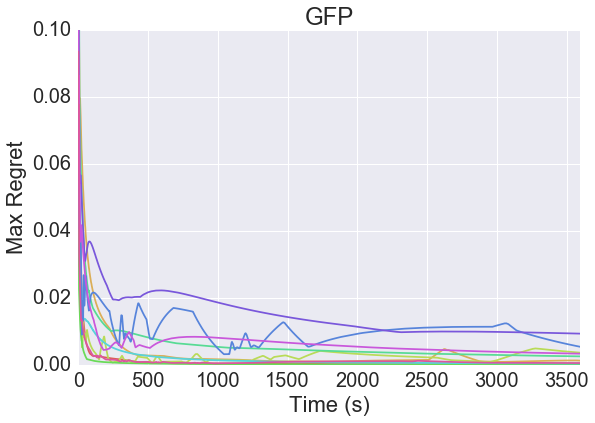

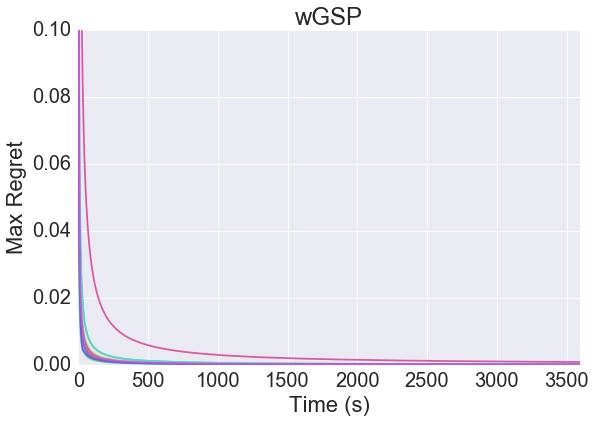

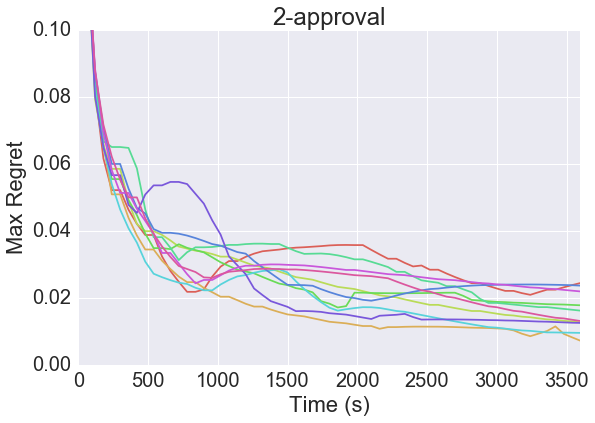

In [82]:
palette = sns.color_palette("hls", 10)
for game, group in fp.groupby(level=0):
    plt.figure(figsize=(9,6))
    for seed, s, in group.groupby(level=1):
        if game.lower() == 'two_approval':
            freq = '60s'
        else:
            freq = '1s'
        median_regret = s.resample(freq,level=2)['weighted_max_regret'].median().values
        if game.lower() == 'two_approval':
            x = range(0,4000,60)[:len(median_regret)]
        else:
            x = range(len(median_regret))
        plt.plot(x, median_regret, color=palette[seed-1])
    plt.xlim(xmin=0,xmax=3600)
    plt.ylim(ymin=0, ymax=0.1)
    plt.ylabel('Max Regret')
    plt.xlabel('Time (s)')
    plt.title(to_nice_name(game))
    figname = 'figures/FP_%s.png' % (game)
    print "saving", figname
    plt.savefig(figname, dpi=300)

In [114]:
def check_result_IBR(df):
    result = 'SAT' if df.tail(1)['weighted_max_regret'].values[0] == 0 else 'TIMEOUT'
    runtime = df.tail(1)['cputime'].values[0]
    if runtime > CUTOFF:
        runtime = TIMEOUT_TIME
        result = 'TIMEOUT'
    return runtime, result

records = []
for output in tqdm(glob.glob('/ubc/cs/research/arrow/newmanne/positronic-economist/IBR/*')):
    name = os.path.basename(output).replace('.txt','')
    matches = re.match("(.+)_n=(\d+)_seed=(\d+)_algseed=(\d+)", name).groups()
    try:
        rt = pd.read_csv(output)
    except Exception:
        print "WARN " + output
        continue
    runtime, result = check_result_IBR(rt)
    record = {
        'bagg_type': 'FINAL',
        'game': matches[0],
        'gnm_seed': int(matches[3]),
        'n_players': int(matches[1]),
        'posec_seed': int(matches[2]),
        'result': result,
        'runtime': runtime,
        'bad': False,
        'config': 'WBSI + BBSI',
     }
    records.append(record)
    
    qq = pd.DataFrame.from_records([record])
    if len(qq[qq.isnull().any(axis=1)]) > 0:
        continue # Still active....
ibr = pd.DataFrame.from_records(records)

In [116]:
ibr[~ibr.isnull().any(axis=1)].to_csv('ibr.csv', index=False)

In [115]:
ibr[ibr.isnull().any(axis=1)]


,bad,bagg_type,config,game,gnm_seed,n_players,posec_seed,result,runtime


In [78]:
frames = []
IBR_FREQ = '20s'
for output in tqdm(glob.glob('/ubc/cs/research/arrow/newmanne/positronic-economist/IBR/GFP_n=10*')):
    name = os.path.basename(output).replace('.txt','')
    matches = re.match("(.+)_n=(\d+)_seed=(\d+)_algseed=(\d+)", name).groups()
    rt = pd.read_csv(output)
    rt['cputime'] -= rt['cputime'][0]
    rt['cputime'] = pd.to_timedelta(rt['cputime'], unit='s')
    rt = rt.set_index('cputime').resample(IBR_FREQ).pad()
    rt = rt.reset_index()
    rt['game'] = matches[0]
    rt['n'] = matches[1]
    rt['seed'] = matches[2]
    rt['ibrseed'] = matches[3]
    frames.append(rt)
ibr_raw = pd.concat(frames)

saving figures/IBR_GFP.png


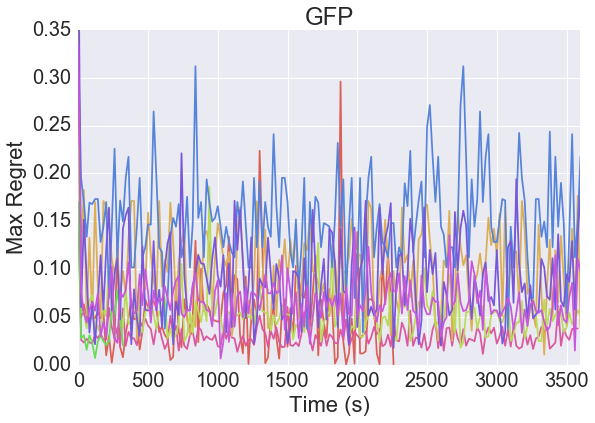

In [81]:
ibr_gfp = ibr_raw.set_index(['game', 'seed', 'cputime'])
palette = sns.color_palette("hls", 10)
for game, group in ibr_gfp.groupby(level=0):
    plt.figure(figsize=(9,6))
    for seed, s, in group.groupby(level=1):
        median_regret = s.resample(IBR_FREQ,level=2)['weighted_max_regret'].median().values
        x = range(0,4000,20)[:len(median_regret)]#range(len(median_regret))
        plt.plot(x, median_regret, color=palette[int(seed)-1])
    plt.xlim(xmin=0,xmax=3600)
    plt.ylim(ymin=0, ymax=0.35)
    plt.ylabel('Max Regret')
    plt.xlabel('Time (s)')
    plt.title(to_nice_name(game))
    figname = 'figures/IBR_%s.png' % (game)
    print "saving", figname
    plt.savefig(figname, dpi=300)